In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:

import pandas as pd
import warnings

warnings.filterwarnings('ignore')


from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM


### Data loading

In [3]:
data = pd.read_pickle('/content/gdrive/MyDrive/eld_filtered_labled.pkl')
data = data.drop('day_of_week',axis=1)
X = data.drop('Consumption',axis=1) # Features (time series data)
y = data['Consumption'] # Labels (0 or 1)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)

In [5]:
print(X_train.shape)

(98179, 370)


### Model defination

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

X_train = X_train.to_numpy()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 370, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 370, 64)           49408     
                                                                 
 dense (Dense)               (None, 370, 1)            65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


### Training

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
3069/3069 [==============================] - 125s 36ms/step - loss: 0.5422 - accuracy: 0.7429 - val_loss: 0.4798 - val_accuracy: 0.7796
Epoch 2/10
3069/3069 [==============================] - 99s 32ms/step - loss: 0.4146 - accuracy: 0.8179 - val_loss: 0.3913 - val_accuracy: 0.8299
Epoch 3/10
3069/3069 [==============================] - 103s 34ms/step - loss: 0.3657 - accuracy: 0.8433 - val_loss: 0.3420 - val_accuracy: 0.8537
Epoch 4/10
3069/3069 [==============================] - 102s 33ms/step - loss: 0.3271 - accuracy: 0.8617 - val_loss: 0.3257 - val_accuracy: 0.8624
Epoch 5/10
3069/3069 [==============================] - 107s 35ms/step - loss: 0.2992 - accuracy: 0.8738 - val_loss: 0.3135 - val_accuracy: 0.8649
Epoch 6/10
3069/3069 [==============================] - 101s 33ms/step - loss: 0.2766 - accuracy: 0.8829 - val_loss: 0.2739 - val_accuracy: 0.8839
Epoch 7/10
3069/3069 [==============================] - 104s 34ms/step - loss: 0.2574 - accuracy: 0.8910 - val_loss: 0.

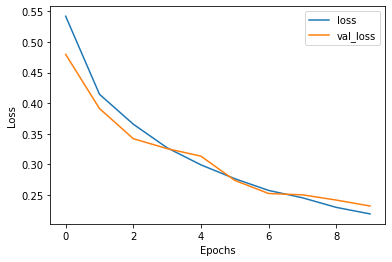

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

### Results

In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')

1315/1315 [==============================] - 18s 14ms/step - loss: 0.2319 - accuracy: 0.9002
Test Loss: 0.232, Test Accuracy: 0.900


In [11]:
y_pred = model.predict(X_test)

1315/1315 [==============================] - 17s 12ms/step


In [12]:
 # Set threshold
threshold = 0.5

# Convert to binary
y_pred_n  = (y_pred>= threshold).astype(int)
np.unique(y_pred_n)

array([0, 1])

In [13]:

y_pred_n = np.argmax(y_pred_n, axis=2).reshape(-1)

In [14]:
np.unique(y_pred)

array([2.2714054e-05, 2.2791257e-05, 2.3290129e-05, ..., 9.9973708e-01,
       9.9974209e-01, 9.9975187e-01], dtype=float32)

In [15]:
y_test

Date
2011-05-05 14:15:00    1
2013-05-20 14:15:00    1
2013-10-25 02:45:00    1
2014-11-18 01:15:00    1
2012-02-10 22:15:00    1
                      ..
2012-05-07 18:30:00    0
2012-06-07 21:15:00    1
2012-08-20 00:15:00    1
2013-11-05 01:15:00    1
2014-04-17 13:00:00    1
Name: Consumption, Length: 42077, dtype: int64

In [16]:
y_test_repeated = np.tile(y_test, 370)
print(y_test_repeated.shape)

(15568490,)


In [17]:
if np.array_equal(y_test,y_test_repeated[:42077]):
    print("Arrays are equal")
else:
    print("Arrays are not equal")


Arrays are equal


In [19]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_repeated, y_pred_n)
print(conf_matrix)

[[ 4816290        0]
 [10752200        0]]


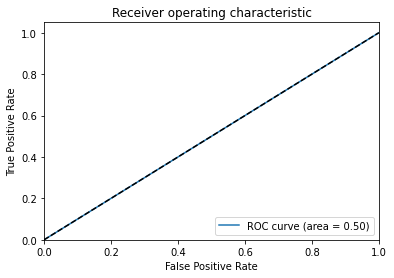

In [20]:
from sklearn.metrics import roc_curve, auc

# y_test and y_pred should be binary (0 or 1)
fpr, tpr, thresholds = roc_curve(y_test_repeated, y_pred_n)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test_repeated, y_pred_n, average='macro')
print(f1)

0.23626892220568482


An accuracy of 0.90 on the test set means that 90% of the samples in the test set were classified correctly by the model. However, an ROC AUC of 0.5 indicates that the model's ability to distinguish between positive and negative samples is no better than random guessing.

This could happen if the model is predicting probabilities that are too close to 0.5 for all samples, meaning that it is essentially guessing randomly. Alternatively, it could be the case that the model is biased towards predicting one class more than the other, resulting in a suboptimal ROC AUC score.

If your F1 score is 0.23626892220568482, it means that the harmonic mean of your model's precision and recall is 0.236. It indicates that your model has a poor balance between precision and recall, and is not performing well overall. You may need to adjust your model's hyperparameters or consider a different model architecture to improve its performance.